## data_process

In [48]:
# coding=utf-8
import numpy as np
import struct
import os

# Load the MNIST data for this exercise
# mat_data contain the training and testing images or labels.
#   Each matrix has size [m,n] for images where:
#      m is the number of examples.
#      n is the number of pixels in each image.
#   or Each matrix has size [m,1] for labels contain the corresponding labels (0 to 9) where:
#      m is the number of examples.
def load_mnist(file_dir, is_images='True'):
    # Read binary data
    bin_file = open(file_dir, 'rb')
    bin_data = bin_file.read()
    bin_file.close()
    # Analysis file header
    if is_images:
        # Read images
        fmt_header = '>iiii'
        magic, num_images, num_rows, num_cols = struct.unpack_from(fmt_header, bin_data, 0)
    else:
        # Read labels
        fmt_header = '>ii'
        magic, num_images = struct.unpack_from(fmt_header, bin_data, 0)
        num_rows, num_cols = 1, 1
    data_size = num_images * num_rows * num_cols
    mat_data = struct.unpack_from('>' + str(data_size) + 'B', bin_data, struct.calcsize(fmt_header))
    mat_data = np.reshape(mat_data, [num_images, num_rows * num_cols])
    print('Load images from %s, number: %d, data shape: %s' % (file_dir, num_images, str(mat_data.shape)))
    return mat_data

# call the load_mnist function to get the images and labels of training set and testing set
def load_data(mnist_dir, train_data_dir, train_label_dir, test_data_dir, test_label_dir):
    print('Loading MNIST data from files...')
    train_images = load_mnist(os.path.join(mnist_dir, train_data_dir), True)
    train_labels = load_mnist(os.path.join(mnist_dir, train_label_dir), False)
    test_images = load_mnist(os.path.join(mnist_dir, test_data_dir), True)
    test_labels = load_mnist(os.path.join(mnist_dir, test_label_dir), False)
    return train_images, train_labels, test_images, test_labels



In [49]:
mnist_dir = "mnist_data/"
train_data_dir = "train-images-idx3-ubyte"
train_label_dir = "train-labels-idx1-ubyte"
test_data_dir = "t10k-images-idx3-ubyte"
test_label_dir = "t10k-labels-idx1-ubyte"
k = 10
iters = 500
alpha = 0.5

In [50]:
os.path.join(mnist_dir, train_data_dir)

'mnist_data/train-images-idx3-ubyte'

In [51]:
train_images, train_labels, test_images, test_labels = load_data(mnist_dir, train_data_dir, train_label_dir, test_data_dir, test_label_dir)

Loading MNIST data from files...
Load images from mnist_data/train-images-idx3-ubyte, number: 60000, data shape: (60000, 784)
Load images from mnist_data/train-labels-idx1-ubyte, number: 60000, data shape: (60000, 1)
Load images from mnist_data/t10k-images-idx3-ubyte, number: 10000, data shape: (10000, 784)
Load images from mnist_data/t10k-labels-idx1-ubyte, number: 10000, data shape: (10000, 1)


In [52]:
train_images.dtype

dtype('int32')

## TRAIN

In [53]:
# train_images = train_images[:5,:]
# train_labels = train_labels[:5,:]
# test_images = test_images[:5,:]
# test_labels = test_labels[:5,:]

In [54]:
train_images
train_labels
test_images
test_labels

array([[7],
       [2],
       [1],
       ...,
       [4],
       [5],
       [6]])

In [55]:
# tranfer the image from gray to binary and get the one-hot style labels
def data_convert(x, y, m, k):
    x[x<=40]=0
    x[x>40]=1
    ont_hot_y = np.zeros((m,k))    
    for t in np.arange(0,m):
        ont_hot_y[t,y[t]]=1
    ont_hot_y=ont_hot_y.T
    return x, ont_hot_y


In [56]:
import matplotlib.pyplot as plt
def softmax_regression(theta, x, y, iters, alpha):
    # TODO: Do the softmax regression by computing the gradient and
    # the objective function value of every iteration and update the theta
    loss_history = []
    for i in range(iters):
        score = np.dot(theta, x.T)  # 计算得分
        score -= np.max(score, axis=0)  # 减去最大值，避免数值上溢
        exp_score = np.exp(score)  # 指数化得分
        probabilities = exp_score / np.sum(exp_score, axis=0)  # 计算概率
        loss = -np.sum(y * np.log(probabilities)) / x.shape[0]  # 计算交叉熵损失
        loss_history.append(loss)
        gradient = np.dot(probabilities - y, x) / x.shape[0]  # 计算梯度
        theta -= alpha * gradient  # 更新theta参数
    # 绘制损失曲线
    plt.plot(loss_history)
    return theta

In [57]:
def train(train_images, train_labels, k, iters = 5, alpha = 0.5):
    m, n = train_images.shape
    # data processing
    x, y = data_convert(train_images, train_labels, m, k) # x:[m,n], y:[1,m]
    
    # Initialize theta.  Use a matrix where each column corresponds to a class,
    # and each row is a classifier coefficient for that class.
    theta = np.random.rand(k, n) # [k,n]
    # do the softmax regression
    theta = softmax_regression(theta, x, y, iters, alpha)
    return theta

array([[0.13066544, 0.92812147, 0.88855025, ..., 0.35534733, 0.69554858,
        0.3982201 ],
       [0.50548528, 0.01688244, 0.24007776, ..., 0.1805773 , 0.83835115,
        0.81776173],
       [0.37057434, 0.12343736, 0.72366109, ..., 0.21188505, 0.90995153,
        0.90109176],
       ...,
       [0.44600842, 0.25514607, 0.50944094, ..., 0.80608162, 0.54949846,
        0.40543243],
       [0.55827385, 0.87676209, 0.38623529, ..., 0.98387167, 0.5861716 ,
        0.70229255],
       [0.0734925 , 0.99139553, 0.18168166, ..., 0.09285487, 0.17060588,
        0.10942842]])

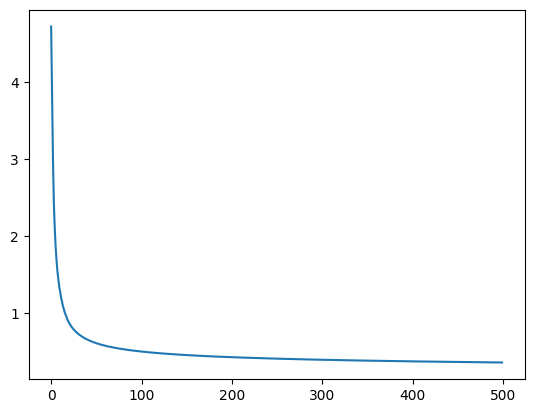

In [58]:
theta = train(train_images, train_labels, k, iters, alpha)
theta

## TEST

In [59]:
def predict(test_images, theta):
    scores = np.dot(test_images, theta.T)
    preds = np.argmax(scores, axis=1)
    return preds

def cal_accuracy(y_pred, y):
    # TODO: Compute the accuracy among the test set and store it in acc
    acc = np.sum(np.equal(y_pred,y.reshape(-1,))) / y.shape[0]
    return acc

In [60]:
y_predict = predict(test_images, theta)
y_predict

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [61]:
accuracy  = cal_accuracy(y_predict, test_labels)
accuracy

0.9064